# Clase práctica 3: ResNet (Copia)

**Profesor de Cátedra:** José M. Saavedra.

**Profesor Auxiliar:** Cristóbal Loyola (cloyola@dcc.uchile.cl)

En esta clase revisaremos en detalle la arquitectura ResNet ([paper](https://arxiv.org/pdf/1512.03385v1.pdf)) con sus diferentes variantes.

Para estudiar el desempeño de este modelo, resolveremos el mismo problema de clasificación de la clase anterior: usaremos el dataset *Impresee-Clothing* que contiene imágenes de prendas de vestir divididas en 19 clases, con 31.977 imágenes para entrenamiento y 1.900 para test.

In [1]:
# Clonamos el repositorio
!git clone https://github.com/alvaro-neira/convnet2.git --branch tfrecords-resnet34

Cloning into 'convnet2'...
remote: Enumerating objects: 287, done.
remote: Counting objects: 100% (287/287), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 287 (delta 182), reused 167 (delta 87), pack-reused 0
Receiving objects: 100% (287/287), 78.10 KiB | 1.30 MiB/s, done.
Resolving deltas: 100% (182/182), done.


In [2]:
!pwd  # muestra el directorio actual
!ls   # muestra el contenido de este (archivos y directorios)

/content
convnet2  sample_data


## Preparación de los datos

In [3]:
# Crear directorios para datos y snapshots
!mkdir /content/convnet2/snapshots
!mkdir /content/convnet2/logs
!mkdir /content/convnet2/data

!ls convnet2

configs   models	      ssearch.py	     train_siamese.py
data	  README.md	      ssearch_with_merge.py  train_simple.py
datasets  release_siamese.py  test_tfrecords.py      utils
logs	  snapshots	      train.py


In [4]:
# Descargar y descomprimir los datos ~4 minutos
%cd /content/convnet2/data
!wget https://www.dropbox.com/s/c3h9e0o6ajydbao/clothing-small.zip
!unzip -q clothing-small.zip
!rm clothing-small.zip
!ls

/content/convnet2/data
--2021-11-12 12:48:34--  https://www.dropbox.com/s/c3h9e0o6ajydbao/clothing-small.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/c3h9e0o6ajydbao/clothing-small.zip [following]
--2021-11-12 12:48:35--  https://www.dropbox.com/s/raw/c3h9e0o6ajydbao/clothing-small.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc756b42084ea97b977118304d6f.dl.dropboxusercontent.com/cd/0/inline/BZ230Iux0m9eh8umfLOGQtlChjoSzOK_X20L6kdXll0iP81AIBGP_OVGSStsO8FyqDjN5m3MmmJyWAnZ0cpfB8qdAK-jJVYDSzo4JGNVFe4A_ocHQZD5y3uUhU5mFr6MDhUbgUfVgvr3VMtj-l1bD_ZK/file# [following]
--2021-11-12 12:48:35--  https://uc756b42084ea97b977118304d6f.dl.dropboxusercontent.com/cd/0/inline/BZ230Iux0m9eh8umfLOGQtlChjoSzOK_X20L6kdXll0iP8

In [5]:
# Generar archivos de texto de train/test

%cd /content/convnet2/data/clothing-small

!awk '{print "data/clothing-small/" $0;}' test_sample.txt > test.txt
!awk '{print "data/clothing-small/" $0;}' train_sample.txt > train.txt

# Podemos ver el número de lineas de cada archivo
!wc -l "test_sample.txt"
!wc -l "train_sample.txt"

!wc -l "test.txt"
!wc -l "train.txt"

/content/convnet2/data/clothing-small
1900 test_sample.txt
31977 train_sample.txt
1900 test.txt
31977 train.txt


## Generación de TFRecords

Ahora convertiremos nuestras imágenes y etiquetas a un formato binario que TensorFlow puede leer de forma eficiente. 

In [6]:
# Creamos los tfrecords ~7 minutos
%cd /content/convnet2
!python datasets/create_tfrecords.py -type all -config configs/clothing_cl.config -name FASHION
!ls data/clothing-small

/content/convnet2
Launching 8 threads for spacings: [[0, 3997], [3997, 7994], [7994, 11991], [11991, 15988], [15988, 19985], [19985, 23982], [23982, 27979], [27979, 31977]]
2021-11-12 12:53:08.449188 Thread 1 --> processing 100 of 3997 [3997, 7994]
2021-11-12 12:53:08.781965 Thread 7 --> processing 100 of 3998 [27979, 31977]
2021-11-12 12:53:08.874168 Thread 4 --> processing 100 of 3997 [15988, 19985]
2021-11-12 12:53:08.953352 Thread 0 --> processing 100 of 3997 [0, 3997]
2021-11-12 12:53:09.010875 Thread 6 --> processing 100 of 3997 [23982, 27979]
2021-11-12 12:53:09.054683 Thread 5 --> processing 100 of 3997 [19985, 23982]
2021-11-12 12:53:09.191846 Thread 2 --> processing 100 of 3997 [7994, 11991]
2021-11-12 12:53:11.619658 Thread 3 --> processing 100 of 3997 [11991, 15988]
2021-11-12 12:53:17.039812 Thread 1 --> processing 200 of 3997 [3997, 7994]
2021-11-12 12:53:17.107226 Thread 5 --> processing 200 of 3997 [19985, 23982]
2021-11-12 12:53:17.228317 Thread 4 --> processing 200 of

## Entrenamiento y test

A continuación, entrenaremos un clasificador con los datos recién generados. 

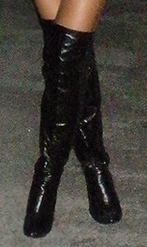

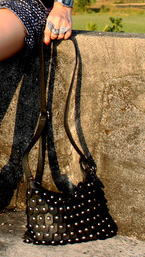

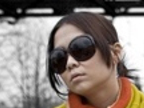

In [7]:
from IPython.display import Image, display

display(Image('/content/convnet2/data/clothing-small/test_sample/450d604d-70fc-4c7e-a.png'))
display(Image('/content/convnet2/data/clothing-small/test_sample/459fc917-ffa8-4b58-9.png'))
display(Image('/content/convnet2/data/clothing-small/test_sample/500a1756-be99-45eb-8.png'))

El modelo predice las clases *pants*, *bag* y *glasses* para las imágenes anteriores, respectivamente. El primer ejemplo es clasificado incorrectamente, mientras que los otros dos ejemplos son bien clasificados pero la probabilidad asignada no es demasiado alta.

Podemos ver que luego de 20 épocas, el modelo alcanza una excelente precisión para los datos de entrenamiento. Sin embargo, no tiene una buena capacidad de generalización (47% de precisión para los datos de test). Para mejorar esta situación, utilizaremos un modelo de mayor complejidad.

### ResNet-34



In [8]:
# ResNet-34 entrenada con decaimiento de learning rate (ver train.py) ~46 minutos
%cd /content/convnet2
!rm -rf snapshots/*
!python train.py -mode train -config configs/clothing_cl.config -name FASHION

/content/convnet2
2021-11-12 13:01:40.847641: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model is Resnet
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  23549568  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          multiple                  38931     
                                                                 
Total params: 23,588,499
Trainable params: 23,543,059
Non-trainable params: 45,440
______________________________________________________

### ResNet-34 (pre-entrenada en ImageNet)

Ahora volveremos a entrenar una ResNet-34, pero comenzando con pesos pre-entrenados en ImageNet. Para esto, agregamos lo siguiente al archivo ```/content/convnet2/configs/clothing_cl.config```:

* ```CKPFILE = /content/convnet2/snapshots/imagenet_045.h5```

In [10]:
%cd /content/convnet2/
!git fetch --all
!git checkout all

# Descargar pesos pre-entrenados
%cd /content/convnet2/snapshots
!wget https://www.dropbox.com/s/ea61crvnckf96ez/imagenet_045.h5

# Entrenar el modelo ~32 minutos
%cd /content/convnet2
!python train_simple.py -mode train -config configs/clothing_cl.config -name FASHION

/content/convnet2
Fetching origin
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/alvaro-neira/convnet2
 * [new branch]      all        -> origin/all
Branch 'all' set up to track remote branch 'all' from 'origin'.
Switched to a new branch 'all'
/content/convnet2/snapshots
--2021-11-12 14:07:58--  https://www.dropbox.com/s/ea61crvnckf96ez/imagenet_045.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6035:18::a27d:5512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/ea61crvnckf96ez/imagenet_045.h5 [following]
--2021-11-12 14:07:58--  https://www.dropbox.com/s/raw/ea61crvnckf96ez/imagenet_045.h5
Reusing existing connection to www.dropbox.com:443.
HTTP req

In [12]:
# Predicciones con ResNet-34 pre-entrenada
%cd /content/convnet2
#!cp /content/drive/MyDrive/2021-2/sección_1/03/snapshots/resnet34_pretrained_020.h5 ./snapshots

!python train_simple.py -mode predict -config configs/clothing_cl.config -name FASHION

/content/convnet2
2021-11-12 14:41:22.112326: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 backbone (ResNetBackbone)   multiple                  21298112  
                                                                 
 global_average_pooling2d (G  multiple                 0         
 lobalAveragePooling2D)                                          
                                                                 
 classifier (Dense)          multiple                  9747      
                                                                 
Total params: 21,307,859
Trainable params: 21,292,627
Non-trainable params: 15,232
_________________________________________________________________
file

Ahora los tres ejemplos sí son clasificados correctamente y con una probabilidad cercana a 1.

Podemos ver que utilizando un modelo ResNet, obtenemos una precisión bastante mayor en los datos de test (65% versus un 47% usando AlexNet). También podemos ver que al utilizar pesos pre-entrenados, el modelo converge mucho más rápido a un accuracy alto.

## TensorBoard

Una herramienta muy útil al momento de comparar modelos es TensorBoard. Para guardar las estadísticas del entrenamiento, podemos crear un callback de la siguiente forma:

```tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=path_to_output_dir, histogram_freq=1)```

Luego basta con agregarlo como argumento al momento de entrenar el modelo (model.fit(...)).

## Métricas

Para obtener un análisis más detallado, podemos usar métricas como precision, recall o una matriz de confusión (ver como referencia la [documentación de sklearn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics)). A continuación, se muestra una comparación entre tres modelos: una ResNet-34 sin pesos pre-entrenados, una ResNet-34 con pesos pre-entrenados en ImageNet, y una ResNet-50.

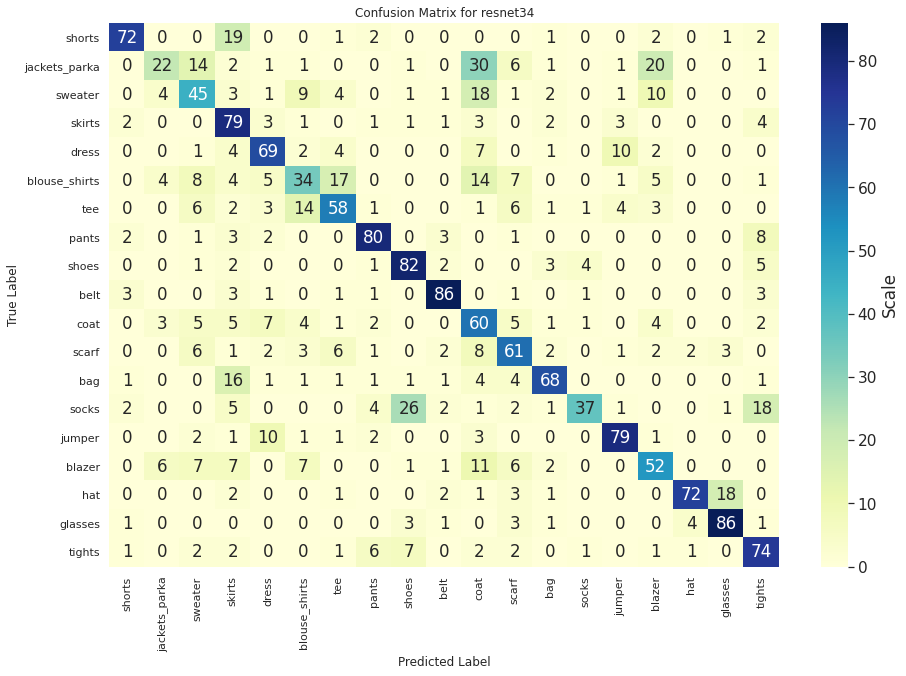

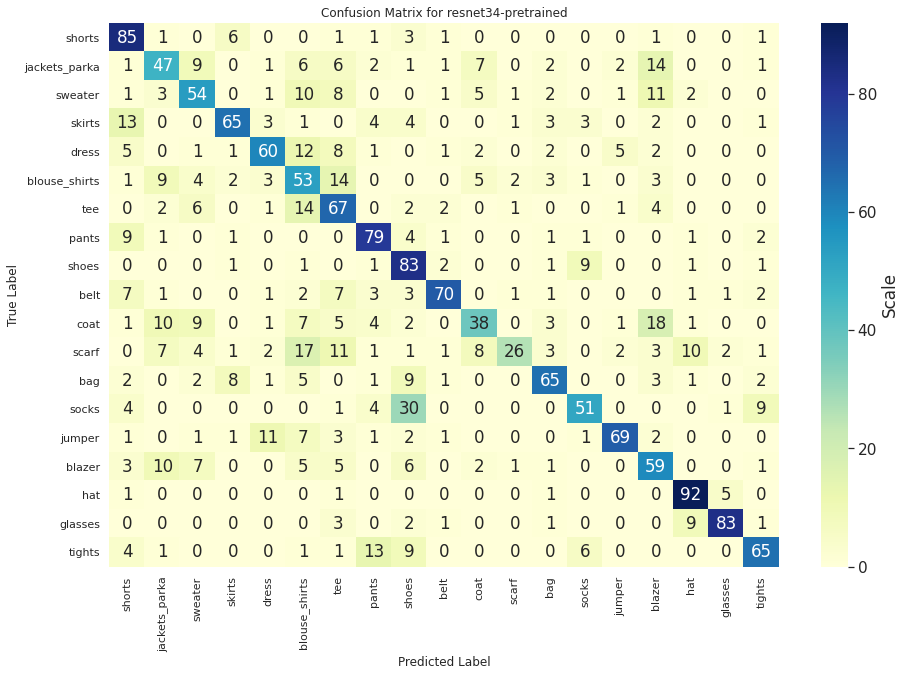

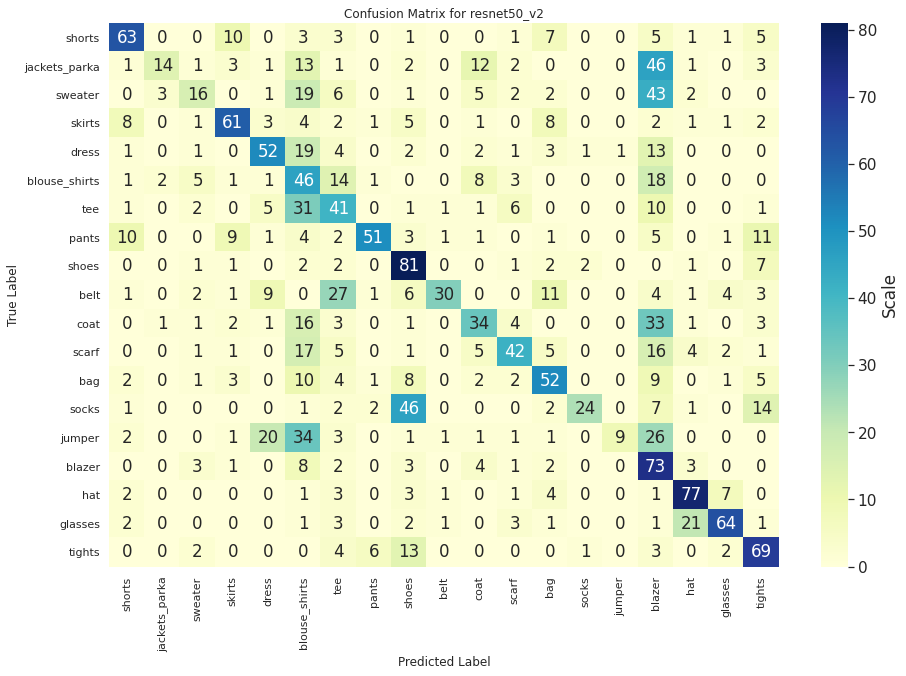

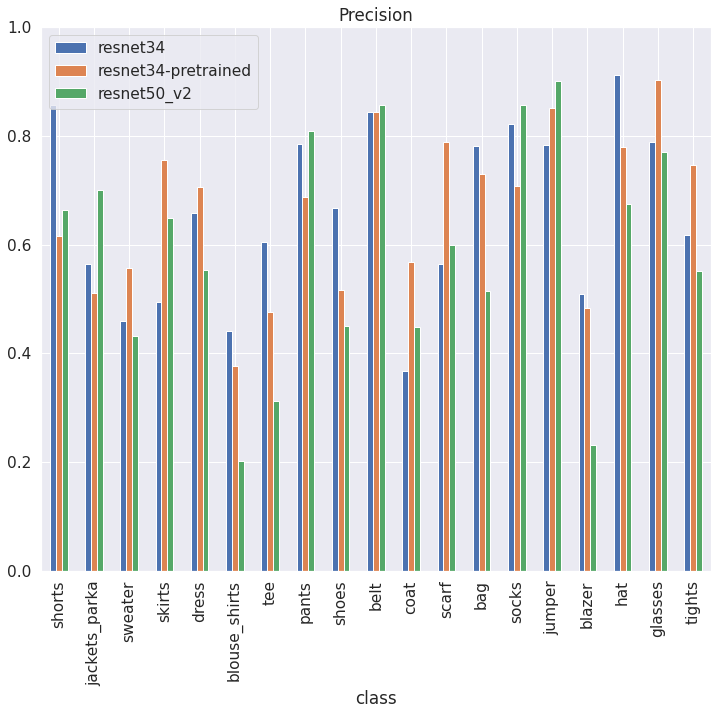

,resnet34,resnet34-pretrained,resnet50_v2,class
0,0.857143,0.615942,0.663158,shorts
1,0.564103,0.510870,0.700000,jackets_parka
2,0.459184,0.556701,0.432432,sweater
3,0.493750,0.755814,0.648936,skirts
4,0.657143,0.705882,0.553191,dress


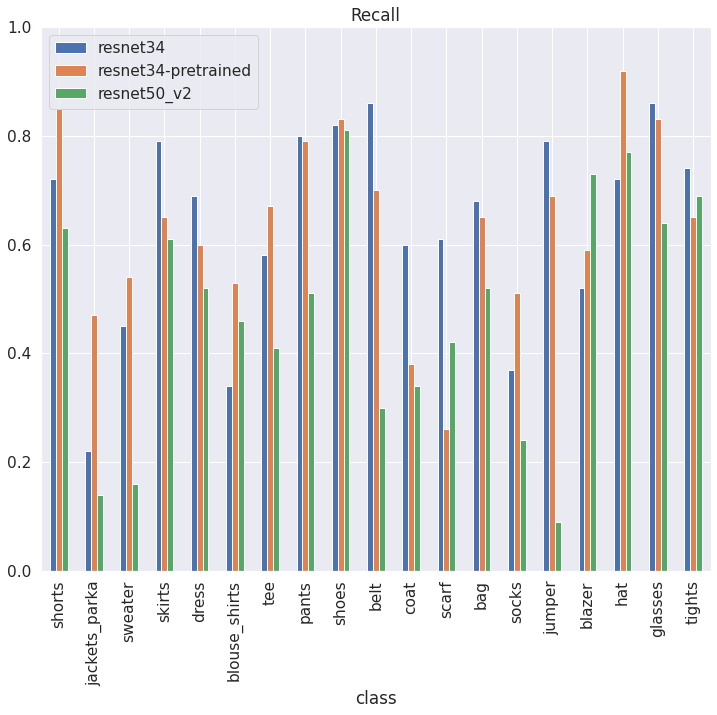

,resnet34,resnet34-pretrained,resnet50_v2,class
0,0.72,0.85,0.63,shorts
1,0.22,0.47,0.14,jackets_parka
2,0.45,0.54,0.16,sweater
3,0.79,0.65,0.61,skirts
4,0.69,0.60,0.52,dress


## Funciones de loss personalizadas

Si bien TensorFlow (y/o Keras) incluye funciones de loss para clasificación, regresión, etc., dependiendo del problema que queramos resolver podríamos llegar a necesitar alguna función de pérdida personalizada. 

Para lograr esto, basta escribir una función que reciba dos tensores: *y_true* (ground-truth, por ejemplo una etiqueta en formato one-hot encoding) e *y_pred* (la salida de la red). Dentro del cuerpo de la función podemos definir las operaciones involucradas en la loss personalizada. Finalmente, debemos agregar la función implementada como argumento al compilar el modelo (model.compile(...)).

Como ejemplo, veremos cómo implementar una función cross-entropy para clasificación:


In [13]:
import tensorflow as tf

# Cross-entropy de Keras
def crossentropy_loss(y_true, y_pred):
    """
    shape of y_true = [B x n_classes]
    shape of y_pred = [B x n_classes]
    This is the classical categorical crossentropy
    """
    ce = tf.keras.losses.categorical_crossentropy(y_true, y_pred, from_logits=True)    
    return ce

# Implementación de cross-entropy 
def crossentropy_custom_loss(y_true, y_pred):
    mask = tf.equal(y_true, 1)  # boolean tensor
    y_pred = tf.keras.activations.softmax(y_pred, axis=1)
    vals = tf.cast(tf.boolean_mask(y_pred, mask), tf.float32)
    ce = tf.reduce_mean(-tf.math.log(vals))
    return ce

In [14]:
y_true = tf.constant([1, 0, 0, 0])  # n_classes
y_pred = tf.constant([3.2, 1.3, 0.2, 0.8])

y_true = tf.expand_dims(y_true, axis=0)  # B x n_classes
y_pred = tf.expand_dims(y_pred, axis=0)

keras_loss = crossentropy_loss(y_true, y_pred)
custom_loss = crossentropy_custom_loss(y_true, y_pred)

print(f"keras_loss = {keras_loss}")
print(f"custom_loss = {custom_loss}")

keras_loss = [0.2546992]
custom_loss = 0.25469931960105896
